In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
%matplotlib inline
import seaborn as sns
import os
from PIL import Image
from scipy import linalg
from IPython.display import Image as Image1, display

In [116]:
path = os.getcwd()
path = os.path.join(path, 'class_images\\nonsmiling_cropped')

In [117]:
os.listdir(path)[0].split('.')[-1]

'jpg'

In [118]:
#convert image to greyscale
img = Image.open(os.path.join(path, os.listdir(path)[1])).convert('L')

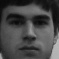

In [119]:
img

In [120]:
np.array(img)

array([[ 12,  11,  11, ...,  49,  51,  39],
       [ 10,  11,  11, ...,  44,  46,  38],
       [  9,  10,  12, ...,  38,  42,  38],
       ...,
       [163, 125,  74, ..., 180, 181, 181],
       [165, 148,  95, ..., 180, 180, 180],
       [163, 163, 108, ..., 180, 180, 179]], dtype=uint8)

In [121]:
a=[]
for i in os.listdir(path):
    if i.split('.')[-1]=='jpg':
        img = Image.open(os.path.join(path, i)).convert('L')
        img = np.array(img)
        a.append(img)

In [122]:
len(a)

36

In [123]:
# Find the min dimensions
w = a[0].shape[0] #width
h = a[0].shape[1] #heigth
for i in a:
    w1=i.shape[1]
    h1 = i.shape[0]
    if w1 < w:
        w = w1
    if h1 < h:
        h = h1
print('min_wdth = {}, min_heigh = {}'.format(w,h))

min_wdth = 49, min_heigh = 49


In [124]:
# center the image make them one min dimensions
def img_proc(i, w, h):  # i - image
    w1=i.shape[1]
    h1 = i.shape[0]
    delit_top = (h1-h)//2
    delit_bottom = (h1-h) - delit_top
    img_reformed = i[delit_top:(h1 - delit_bottom),:]
    
    delit_left = (w1 - w)//2
    delit_right = (w1 - w) - delit_left
    img_reformed = img_reformed[:,delit_left:(w1 - delit_right)]
    return img_reformed
    
a_reformed = []
for i in a:
    a_reformed.append(img_proc(i, w, h))

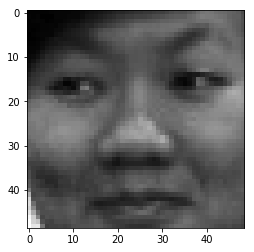

In [125]:
#show the last image
imshow(a_reformed[-1], cmap = 'gray')

In [126]:
# Construct the matrix with all i,mages
images = np.stack(a_reformed,0)
images.shape

(36, 49, 49)

In [127]:
#center the images
avg_face = np.ma.average(images,axis = 0)
images_cent = (images - avg_face)

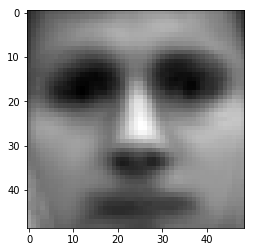

In [128]:
# show the mean image
imshow(np.ma.average(images,axis = 0), cmap = 'gray')

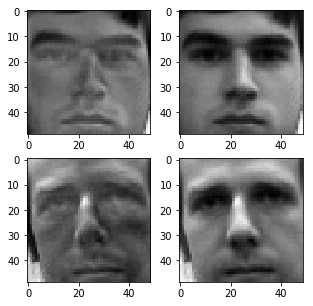

In [129]:
#show the few samples before and after centering
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0,0].imshow(images_cent[1], cmap = 'gray')
axs[0,1].imshow(images[1], cmap = 'gray')
axs[1,0].imshow(images_cent[20], cmap = 'gray')
axs[1,1].imshow(images[20], cmap = 'gray')

In [130]:
# reform the image_cent to flattern array
n = images_cent.shape[0]
n1 = images_cent.shape[1] * images_cent.shape[2]
im = np.reshape(images_cent,(n,n1))
im = np.array(im)
im.shape

(36, 2401)

In [131]:
# use PCA, If do not use Transpose operation - V matrix should be used to get an eigenvectors
U, S, V = linalg.svd(im.T)
print('U_shape: {}, S_shape: {}, V_shape = {}'.format(U.shape, S.shape, V.shape))

U_shape: (2401, 2401), S_shape: (36,), V_shape = (36, 36)


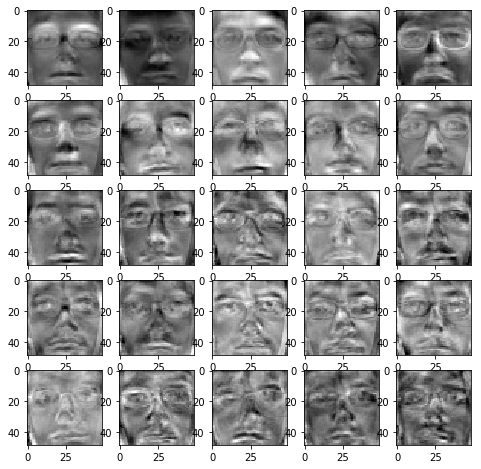

In [132]:
# Lets plot a first eigenface (here we call eigenvector as eigenface)
#show the few samples before and after centering
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
n=0
for i in range(5):
    for j in range(5):  
        axs[i,j].imshow(np.reshape(U[:,n], (49,49)), cmap = 'gray')
        axs[i,j].imshow(np.reshape(U[:,n+1], (49,49)), cmap = 'gray')
        axs[i,j].imshow(np.reshape(U[:,n+2], (49,49)), cmap = 'gray')
        axs[i,j].imshow(np.reshape(U[:,n+3], (49,49)), cmap = 'gray')
        n=n+1

In [195]:
# Now lets try to get our image with only 10 firs eigenfaces
U_reduc = U[:,:10]
face = im[0,:]
new_feature = np.dot(face, U_reduc)
new_feature.shape

(10,)

In [134]:
U_reduc.shape

(2401, 10)

In [135]:
# reconstruct face
face_rec = np.dot(new_feature, U_reduc.T)
face_rec = np.reshape(face_rec, (49,49))

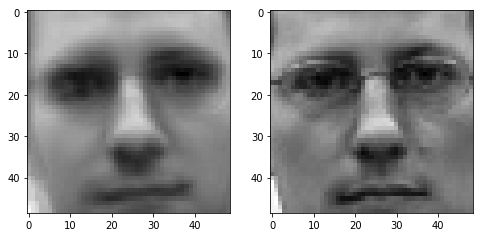

In [136]:
# first is image after reduciton, second is original (mean face), also add avg_face to get the real face
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(face_rec+avg_face, cmap = 'gray')
axs[1].imshow(images_cent[0]+avg_face, cmap = 'gray')

In [137]:
# projecting the potential face onto face space and computing the mean squared error (MSE) between the 
# projection and the original. Try for all 36 images
face_proj = np.dot(im, U_reduc)
face_proj.shape

(36, 10)

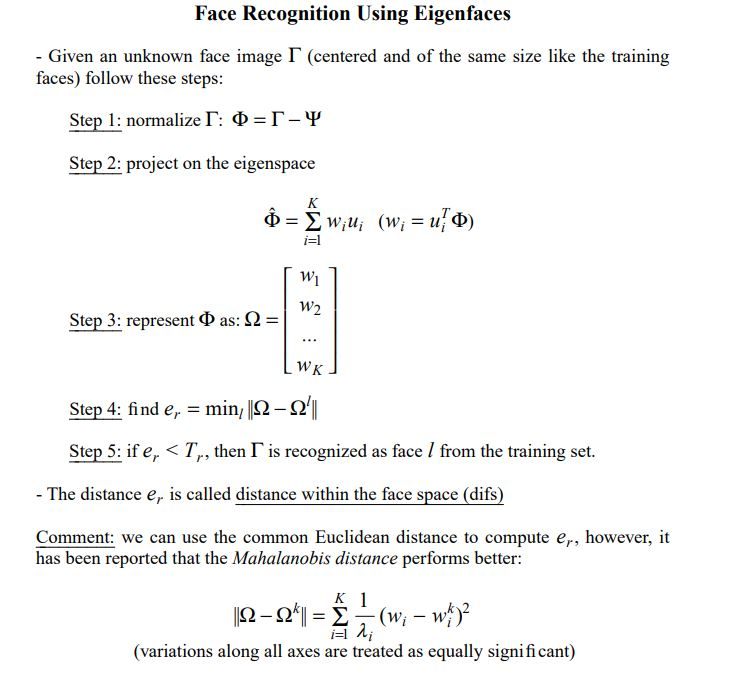

In [138]:
#http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf
display(Image1(filename='img1.JPG', embed=True, width=500))

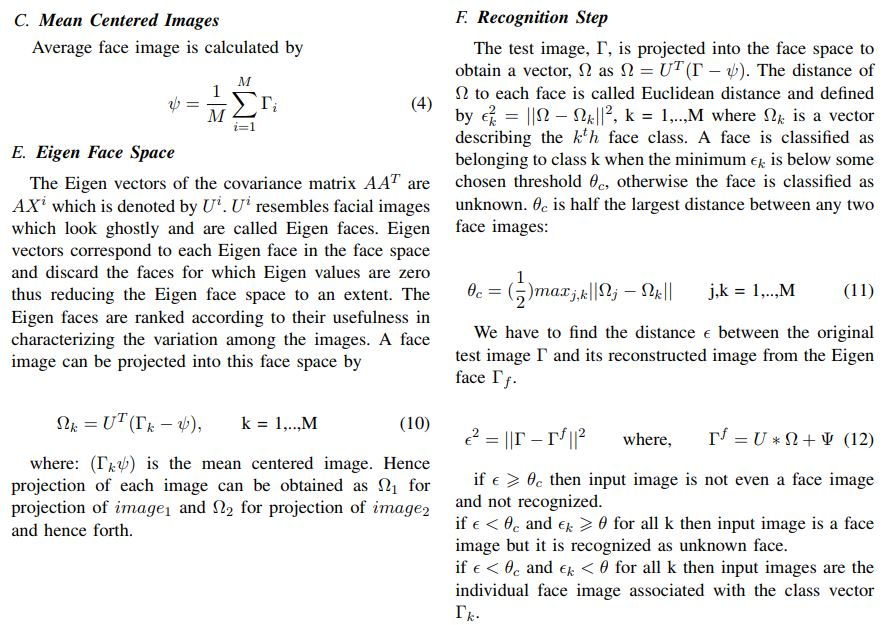

In [167]:
#https://arxiv.org/pdf/1705.02782.pdf
display(Image1(filename='img2.JPG', embed=True, width=800))
# We can use criteria below to face recognition and face detection

In [139]:
# flatten avg_face
avg_face_flat = avg_face.flatten()

In [170]:
# function to proect image on eigenfaces and convert it back
def eign_back(avg_face, image, n):
    image = image - avg_face
    U_reduc = U[:, :n]
    image_eign = np.dot(image, U_reduc)
    image = np.dot(image_eign, U_reduc.T)
    return image
def eign(im, U, n):
    U_reduc = U[:, :n]
    image_eign = np.dot(im, U_reduc)
    return image_eign

In [206]:
# To summarize all above lets create a function which take the images grom the folder, process them and gives back
# a matrix with flatten images
#Note that images in the test folder should be not less than wxh format
def img_process(w=w, h=h, p = 'class_images\\test'):
    path = os.getcwd()
    path = os.path.join(path, p)
    a=[]
    for i in os.listdir(path):
        if i.split('.')[-1].lower()=='jpg':
            img = Image.open(os.path.join(path, i)).convert('L')
            img = np.array(img)
            a.append(img)
    # center the image make them one min dimensions
    
    a_reformed = []
    for i in a:
        a_reformed.append(img_proc(i, w, h))
    # Construct the matrix with all i,mages
    images = np.stack(a_reformed,0)
    # reform the image_cent to flattern array
    n = images.shape[0]
    n1 = images.shape[1] * images.shape[2]
    im_test = np.reshape(images,(n,n1))
    im_test = np.array(im_test)
    return im_test

In [207]:
im_test = img_process(w=w, h=h, p = 'class_images\\test')

In [234]:
# Find the max half dist between face projections (theta_c, from the page above)
max_mse = 0
image_eign = eign(im, U, 100)
for i in range(im.shape[0]):
    mse = np.max(np.mean((image_eign - image_eign[i,:]),axis = 1))*0.5
    if mse >  max_mse:
        max_mse = mse
max_mse

36.312482471604284

In [246]:
# check which from the pictures in test folder is a face
def is_image(im_test, avg_face_flat, max_mse, centered=False):
    answ = []
    if centered==True:
        avg_face_flat=0
    for i in range(im_test.shape[0]):
        aa = eign_back(avg_face_flat, im_test[i,:], 100)
        mse_test = np.mean((aa + avg_face_flat - im_test[i,:])**2)
        if mse_test<=max_mse:
            answ.append('face')
        else:
            answ.append('not face')
    return answ
is_image(im_test, avg_face_flat, max_mse)

['not face', 'not face']

In [247]:
# check on the train data, centered=False since the im values are centered (avg_face is substituted already)
is_image(im, avg_face_flat, max_mse, centered=True)

['face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face',
 'face']